The big chicken-and-egg problem in power analysis is effect size. To calculate the required sample size for a new experiment, we need an estimate of standardized effect size. But it seems unlikely that the experiment would be interesting to us if we already knew that much. The accepted solution is to find a paper that reports something comparable, and base our sample size calculations on these reported effects. In this notebook I demonstrate that that can be a *horrible* idea.

Before we begin it might be worth checking that you are up to speed on the materials [from my last power notebook](power_1.ipynb), where we covered how reproducibility is influenced by statistical power $1-\beta$ and the adopted significance threshold $\alpha$.

In [1]:
# imports
import numpy as np
from scipy import stats
import pandas as pd
import joblib
import statsmodels.stats.power
import altair as alt
# render as svg to avoid embedding full data
# (standard vega-lite behavior)
alt.renderers.enable('altair_saver', fmts=['svg'], method='node')

# this class from statsmodels is useful
ttest_paired = statsmodels.stats.power.TTestPower()

## Preliminaries: Standardized effect size metrics
For parametric statistics applied to continuous data (that is, comparing means), the relevant effect sizes we need for power calculations are standardized mean differences (Cohen's $d$), or measures of association strength (typically partial eta-squared, $\eta_p^2$). The latter group is mainly relevant for ANOVA and regression-based designs where your comparisons involve more than two means, and we will not discuss them further in this notebook.

There are *many* flavours of $d$, which fall into two broad categories for between-subjects unpaired (Cohen's $d_s$) and within-subjects paired (Cohen's $d_z$) $T$ test designs. Within each category there are further variants that differ in how the standard deviation is estimated. Fortunately, most of this complexity arises when combining evidence over experiments in a meta analysis rather than when performing sample size calculations, so we can safely ignore the issue here ([Lakens, 2013](https://doi.org/10.3389/fpsyg.2013.00863) is an accessible review, see also [this blog by Jake Westfall](http://jakewestfall.org/blog/index.php/2016/03/25/five-different-cohens-d-statistics-for-within-subject-designs/)). But it's worth remembering this complexity when $d$ is reported in papers - the reported $d$ may not be what you need for power analysis.

### Power for paired $T$ designs: Cohen's $d_z$
For a paired $T$ test (or equivalently, a one-sample $T$), we obtain $d_z$ by simply taking the mean difference divided by the sample standard deviation of the difference scores. There is also a handy conversion from $T$ to $d$:

$$d_z = T / \sqrt{N}$$

### What's a typical $d_z$ in my research?
Hard to say! It's kind of the point of this notebook to demonstrate how hard it is to get a good estimate for this. The best answer probably comes from large consortium studies with open code and data. My favourite example from cognitive neuroscience is in [Poldrack et al. (2017)](https://doi.org/10.1038/nrn.2016.167),  Box 2. The analysis is by Joke Durnez ([code here](https://github.com/poldracklab/ScanningTheHorizon/tree/master/Box2_EffectSize)) and reports fMRI data from the [Human Connectome Project](https://en.wikipedia.org/wiki/Human_Connectome_Project) dataset ($N=186$):
![Poldrack et al., 2017](images/Poldrack_Scanning_2017.png)

The brain regions on the vertical axis are selected independently with [Neurosynth](https://neurosynth.org/), and the histograms for $d$ in the right panel show the distribution of effect size over voxels for particular contrasts. The authors don't describe the $d$ variant they are reporting unambiguously, but the open [analysis code](https://github.com/poldracklab/ScanningTheHorizon/blob/98d4fc12cdadc4bdc53f86a9e843e8b36fbda29a/Box2_EffectSize/EffectSize/EffectSize.py#L36) shows that it is $d_z$, converted from a T statistic as in the formula above. Which is the variant we need for sample size calculations.

The median estimates are at about $d_z=0.5$ (black dots). So let's start with that in our simulations below. In the following we will assume a sample size of $N=20$, which is fairly typical for the field (see Fig 1 in Poldrack et al., 2017).

In [2]:
# sample size and population effect size
n = 20
d_pop = 0.5
alternative = "two-sided"
alpha = 0.05
power = 0.8
achieved_power = ttest_paired.solve_power(
    effect_size=d_pop, alpha=alpha, nobs=n, alternative=alternative
)
print(
    f"power (d_z={d_pop}, N={n}, alpha={alpha}, {alternative}): \
    {achieved_power:.2}"
)
# how many samples would we need to achieve 80% power?
n_for_80 = ttest_paired.solve_power(
    effect_size=d_pop, alpha=alpha, power=power, alternative=alternative
)
print(f"required N (power={power*100:.0f}%): {np.ceil(n_for_80):.0f}")

power (d_z=0.5, N=20, alpha=0.05, two-sided):     0.56
required N (power=80%): 34


We don't quite achieve the benchmark 80% power with this sample size - we would need 34 subjects for that. Which is also typical for the field - low power is a common problem in neuroscience ([Button et al., 2013](https://doi.org/10.1038/nrn3475)).

## Simulating a simple paired $T$ experiment
Let's use simulations to understand what the parameters above mean in practice for a researcher working in the field. Here is how one experiment might play out:

In [14]:
def simulate_iteration(d_pop, n, alpha=alpha, power=power, alternative=alternative):
    # we can simulate a mean difference by drawing from a Gaussian with d_pop offset
    ttest = stats.ttest_1samp(np.random.randn(n) + d_pop, 0)
    dz = ttest.statistic / np.sqrt(n)
    required_n = ttest_paired.solve_power(
        effect_size=dz, alpha=alpha, power=power, alternative=alternative
    )
    return {
        "t": ttest.statistic,
        "p": ttest.pvalue,
        "d_z": dz,
        "required_n": required_n,
        "significant": ttest.pvalue < alpha,
    }


result = simulate_iteration(d_pop, n)
print(f"d_z_hat: {result['d_z']:.2f}")
print(f"N_hat ({power*100:.0f}% power): {np.ceil(result['required_n']):.0f}")

d_z_hat: 0.73
N_hat (80% power): 17


We entered a ground-truth effect size of $d_z=0.5$ in the simulation. But if we run the above code cell a few times to simulate repeated experiments with $N=20$, we'll see that the estimate $\hat{d}$ can work out quite differently.

## Variability of effect size estimates
Suppose that the above estimate was all we knew about the real effect, and we used it to calculate sample sizes for a new study. We might already suspect that this is going to go badly, but how much of a problem is it really? Let's simulate how this works out over a population of experiments that all explore the same ground-truth effect.

In [4]:
# simulate datasets
n_iter = 5000


def simulate_data(n_sim, d_pop, n):
    with joblib.parallel_backend("threading"):
        result = joblib.Parallel()(
            joblib.delayed(simulate_iteration)(d_pop, n) for x in range(n_sim)
        )
    return pd.DataFrame(result)


dz_sim = simulate_data(n_iter, d_pop, n)

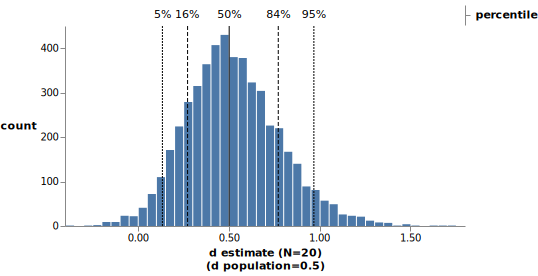

In [5]:
# visualise with a histogram
def histogram(dz_sim, x_axis, color_significance=True):
    """Plot frequency histogram."""

    color_arg = {}
    if color_significance:
        color_arg = dict(color="significant:N")
    # NB the width and height arguments here control the overall size of the plot
    return (
        alt.Chart(dz_sim, width=400, height=200)
        .mark_bar()
        .encode(x=x_axis, y=alt.Y("count()", title="count"), **color_arg)
    )


def gridlines(dz_q, title, format=".0%"):
    """add dashed vertical lines to plot. Label the lines in a second panel 
    with a second right axis."""
    # overlay vertical lines at particular percentiles
    vlines = (
        alt.Chart(dz_q)
        .mark_rule()
        .encode(x="value:Q", strokeDash=alt.StrokeDash("style:O", legend=None),)
    )
    # label the vertical lines with a new axis
    vlabels = (
        alt.Chart(dz_q)
        .mark_text(align="center", baseline="middle", angle=0, dy=0, dx=0)
        .encode(
            text=alt.Text("prob:Q", format=format),
            x=alt.X("value:Q", axis=None),
            y=alt.Y(
                "y:O",
                axis=alt.Axis(labels=False, orient="right", titleAlign="left"),
                title=title,
            ),
        )
    )
    return vlines, vlabels


def style_chart(handle):
    """Make the final chart pretty."""
    return (
        handle.configure_axis(grid=False)
        .configure_view(strokeWidth=0)
        .resolve_scale(x="shared")
        .configure_concat(spacing=0)
        .configure_axisY(titleAngle=0, titleAlign="right", titleBaseline="middle")
    )


xticks = np.arange(np.round((d_pop - 5) * 2) / 2, np.round((d_pop + 5) * 2) / 2, 0.5)

hist = histogram(
    dz_sim,
    alt.X(
        "d_z:Q",
        bin=alt.Bin(anchor=0, maxbins=50),
        axis=alt.Axis(values=xticks),
        title=[f"d estimate (N={n})", f"(d population={d_pop:.1})"],
    ),
    color_significance=False,
)

# add percentiles of distribution
prctiles = np.sort(np.concatenate([stats.norm.cdf([0, -1, 1]), [0.05, 0.95]]))
dz_grid = pd.DataFrame(
    {
        "prob": prctiles,
        "value": np.percentile(dz_sim["d_z"], 100 * prctiles),
        "style": [2, 1, 0, 1, 2],
        "y": 0,
    }
)

vlines, vlabels = gridlines(dz_grid, "percentiles")
style_chart(vlabels & (hist + vlines))

The histogram above summarizes the $\hat{d}$ estimates for all the simulated experiments. There is quite a bit of variability around the ground-truth $d_z=0.5$. For instance, the central 68% of the distribution (analogous to 1 standard deviation about the mean for a Gaussian) runs from around 0.25 to 0.75 for the simulated $N=20$ scenario.

### Analytical approximation of effect size variance

By the way, we don't have to do numerical simulations to obtain a standard-deviation estimate for $d_z$ - there is a large-sample approximation ([Gibbons et al., 1993](https://doi.org/10.3102%2F10769986018003271)):

$$\sigma[d_z] = \sqrt{\frac{1}{n} + \frac{d_z^2}{2 \times n}}$$

How does the parametric approximation compare to the percentiles in our simulated distribution? Let's compare:

In [6]:
# Gibbons et al approximation
def dz_std(d, n):
    return np.sqrt(1.0 / n + (d ** 2) / (2 * n))


dz_var = dz_std(d_pop, n)
print(f"sigma(d_z) parametric approximation\n\t{dz_var:.2f}")
# how does that compare to the percentiles of our distribution?
lower = (
    dz_grid.loc[dz_grid["prob"] == stats.norm.cdf(0), "value"].values
    - dz_grid.loc[dz_grid["prob"] == stats.norm.cdf(-1), "value"].values
)
upper = (
    dz_grid.loc[dz_grid["prob"] == stats.norm.cdf(1), "value"].values
    - dz_grid.loc[dz_grid["prob"] == stats.norm.cdf(0), "value"].values
)
print(f"simulated sigma(d_z)\nlower:\t{lower[0]:.2f}\nupper:\t{upper[0]:.2f}")

sigma(d_z) parametric approximation
	0.24
simulated sigma(d_z)
lower:	0.23
upper:	0.27


Not too bad. So we don't need to resort to simulations to have an idea of how variable a given $d_z$ estimate is likely to be - we just need the sample size of the study the estimate came from.

### Consequences for sample size calculations
Let's make this a bit more concrete by calculating the sample sizes that would result if you used the estimated $\hat{d}$ from one of these experiments to power a new study.

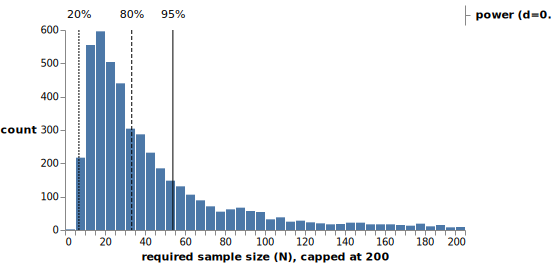

In [7]:
hist_n = histogram(
    dz_sim,
    alt.X(
        f"required_n:Q",
        bin=alt.Bin(anchor=0, maxbins=50, extent=[0, 200]),
        title="required sample size (N), capped at 200",
    ),
    color_significance=False,
)

power_values = np.array([0.2, 0.8, 0.95])
dz_n = pd.DataFrame(
    {
        "prob": power_values,
        "value": [
            ttest_paired.solve_power(
                effect_size=d_pop, alpha=0.05, power=this_power, alternative="two-sided"
            )
            for this_power in power_values
        ],
        "style": [2, 1, 0],
        "y": 0,
    }
)

vlines_n, vlabels_n = gridlines(dz_n, f"power (d={d_pop})")
style_chart(vlabels_n & (hist_n + vlines_n))

This is a long-tailed distribution since the required sample size goes to infinity as the sample effect size approaches zero (notice that I only plot bins up to n=200 - there are values into the thousands). The overlaid vertical lines indicate the achieved power for the *population* effect size. The median of the sample-size distribution is close to the size that achieves 80% power:

In [8]:
print("N (median estimate): {x:.2f}".format(x=dz_sim["required_n"].median()))
print(
    "N (ground truth, {power:.0f}% power): {x:.2f}".format(
        x=n_for_80, power=power * 100
    )
)

N (median estimate): 32.99
N (ground truth, 80% power): 33.37


So on ~~average~~ median, we are getting a reasonable answer by powering new studies based on an underpowered initial study. We are as likely to end up under- or over-powered. But let's appreciate that there is *a lot* of variability. If you calculate sample sizes according to any one of these estimates, you could easily end up with a sample size that is  underpowered with respect to the ground-truth effect size, or with a calculation that suggests an astronomical sample size would be required for adequate power. You might just give up at that point instead of running further studies. Which brings us to the next point...

## Bias in effect size estimates
A $\hat{d}$ estimate from a small previous study is not only going to be an uncertain estimate, in practice it will probably be *biased* too. There are many bias sources, but the most obvious arises from the combination of null-hypothesis significance testing and the well-known reluctance to publish non-significant tests (the [file drawer problem](https://en.wikipedia.org/wiki/Publication_bias)). It's unlikely we would be planning a new study unless the previous study had significant tests, so let's suppose we are only going to consider the part of the $\hat{d}$ distribution that achieved significance:

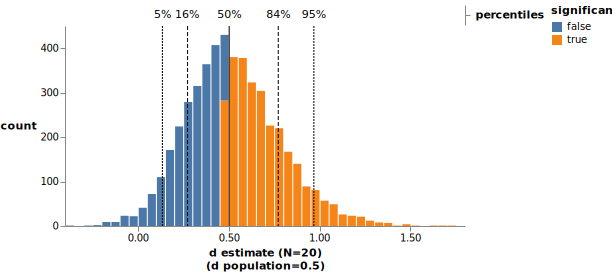

In [9]:
# histogram of d over simulations, coloured by significance
hist_sig = histogram(
    dz_sim,
    alt.X(
        "d_z:Q",
        bin=alt.Bin(anchor=0, maxbins=50),
        axis=alt.Axis(values=xticks),
        title=[f"d estimate (N={n})", f"(d population={d_pop:.1})"],
    ),
    color_significance=True,
)

style_chart(vlabels & (hist_sig + vlines))

We saw previously that power is just over 50% for this simulation, so we should not be surprised to see that roughly that proportion of the simulations produced significant tests. What if those significant tests were all that we knew about the effect size, and we went ahead and calculated sample size requirements using only those results?

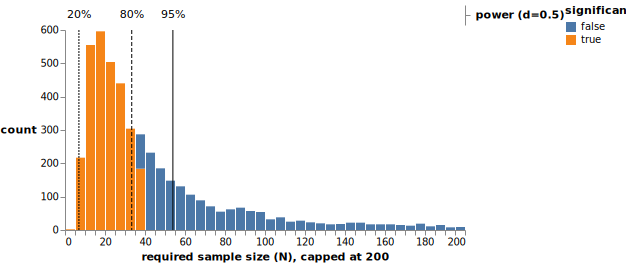

In [10]:
hist_n_sig = histogram(
    dz_sim,
    alt.X(
        f"required_n:Q",
        bin=alt.Bin(anchor=0, maxbins=50, extent=[0, 200]),
        title="required sample size (N), capped at 200",
    ),
    color_significance=True,
)

style_chart(vlabels_n & (hist_n_sig + vlines_n))

Notice how nearly the entire distribution of sample sizes for significant tests falls in range of the horizontal axis where power is less than 80% for the ground-truth effect size.

In [11]:
# compare with the median sample size from the unbiased case above
print(
    "N (median estimate, significance-filtered, p<{alpha}): {x:.2f}".format(
        x=dz_sim.loc[dz_sim["significant"] == 1, "required_n"].median(), alpha=alpha
    )
)
print(
    "N (ground-truth, {power:.0f}% power): {x:.2f}".format(
        x=n_for_80, power=power * 100
    )
)

N (median estimate, significance-filtered, p<0.05): 20.19
N (ground-truth, 80% power): 33.37


Indeed, the median sample size for significant experiments is almost the same as the sample size we started with! By only analysing the significant tests, our sample size recommendations end up close to the sample sizes of the studies that went into the calculation, even if those studies were actually underpowered!

To drive this home, let's scale up our simulation a bit to consider other effect and sample sizes.

In [12]:
# calculate simulations for all options (careful, this cell is slow)
dz_fullsim = {}
for this_d in np.arange(0.2, 0.9, 0.1):
    dz_fullsim[this_d] = {}
    for this_n in [10, 20, 40, 80]:
        dz_fullsim[this_d][this_n] = simulate_data(n_iter, this_d, this_n)

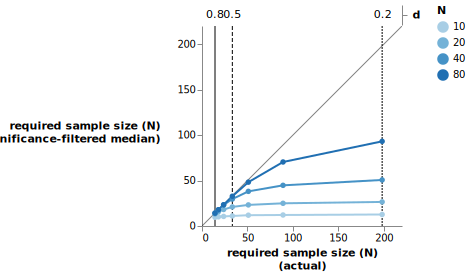

In [13]:
# the easiest thing to do is to just plot the medians.
# first we work out what the required_n was for each d
required_n_actual = {
    this_d: ttest_paired.solve_power(
        effect_size=this_d, alpha=0.05, power=0.8, alternative="two-sided"
    )
    for this_d in dz_fullsim.keys()
}

# flatten the nested dicts to a dataframe with median significance-filtered n
# and actual n in columns
df_fullsim = pd.DataFrame(
    [
        {
            "dz": this_d,
            "n": this_n,
            "required_n_median": this_dz.loc[
                this_dz["significant"] == 1, "required_n"
            ].median(),
            "required_n_actual": required_n_actual[this_d],
        }
        for this_d, this_d_dict in dz_fullsim.items()
        for this_n, this_dz in this_d_dict.items()
    ]
)

# axis limits: round up to nearest 10 and add pad to avoid second axis clipping
# labels
max_n = np.ceil(max(required_n_actual.values()) / 10) * 10 + 5

# plot actual vs significance-filtered sample size requirements in points
points = (
    alt.Chart(df_fullsim)
    .mark_line(point=True)
    .encode(
        x=alt.X(
            "required_n_actual",
            title=["required sample size (N)", "(actual)"],
            scale=alt.Scale(domain=[0, max_n]),
        ),
        y=alt.Y(
            "required_n_median",
            title=["required sample size (N)", "(significance-filtered median)"],
            scale=alt.Scale(domain=[0, max_n]),
        ),
        color=alt.Color("n:O", title="N"),
    )
    .properties(width=200, height=200)
)


# plot a subset of effect sizes as vertical lines
plot_d = [.2, .5, .8]
dz_d_grid = pd.DataFrame(
    {
        "prob": plot_d,
        "value": [
            ttest_paired.solve_power(
                effect_size=this_d, alpha=0.05, power=0.8, alternative="two-sided"
            )
            for this_d in plot_d
        ],
        "style": [2, 1, 0],
        "y": 0,
    }
)
vlines_d, vlabels_d = gridlines(dz_d_grid, "d", format=".1")

# unity line
unity = (
    alt.Chart(pd.DataFrame({"x": [0, max_n * 2], "y": [0, max_n * 2]}))
    .mark_line(color="black", opacity=0.5, size=1, clip=True)
    .encode(x="x", y="y")
)

style_chart(vlabels_d & (vlines_d + unity + points))

The points show the results for a particular effect size ($d_z$ from 0.2 to 0.8 in 0.1 increments) and sample size ($N$, in colours). The connecting lines are just illustrative (there is probably a way to work out an analytical function for this - let me know if you have a solution).

If all was well, the points would be found along the unity line, indicating that the estimated (vertical axis) and actual (horizontal axis) $N$ are similar. In fact, the estimated $N$ shows a strongly saturating behaviour, with an asymptote just over the original $N$ of the studies that went into the power analysis.

In other words, the sample size of the original studies (in colours) tends to be a better predictor for the result of the sample size calculation than the ground-truth requirements. If a literature is underpowered *and* suffers from publication bias, naive application of power calculations will tend to perpetuate the problem.

And that's the curse of low statistical power.

## Is it just publication bias that we have to worry about?
Hardly! In the above simulations, we could instead think of the distribution over experiments as a distribution *within-experiment* over fMRI voxels, gene expression values, or any other feature dimension over which we are selecting effects to report.

The situation is often worse within-experiment, because we tend to focus on the peak rather than values over some threshold, and with stronger selection there is more bias. This is why the Poldrack et al. (2017) $d$ plot that we began with cleverly focused on *median* power over fMRI voxels in independently-selected brain regions.

For instance, if we use the [best-available tool for fMRI power analysis](http://fmripower.org/) with default parameters, it reports power for each of the 90 regions in the [AAL atlas](https://en.wikipedia.org/wiki/Automated_Anatomical_Labeling).  If we simply take the peak region in that map and work out sample sizes for that, that estimate is biased, and our new experiment is likely to end up underpowered.

## Conclusions

* It's a bad idea to perform power calculations based on small previous studies because Cohen's $d_z$ is quite variable at typical sample sizes. We have seen that sample size calculations are *very* sensitive to small differences in estimated effect size, which compounds the issue. This is also the reason why it's a mistake to use 'pilot' studies to estimate effect size.
* If there is any selection bias (for instance, you are using an estimate from a non-preregistered publication, or the peak feature over a brain map), your power calculations are likely to end up optimistic in the extreme. With significance filtering you tend to end up paradoxically recommending the same sample size the previous study had, regardless of actual power. With the peak feature approach the situation actually gets more extreme, and you often end up recommending *smaller* samples than the original study had, regardless of actual power.
* Avoid these problems by getting effect size estimates from large consortium studies, where we have the sample size to expect a smaller standard deviation for $d_z$ and sufficiently standardised protocols to minimise bias. This will probably mean powering according to an effect that is rather different from our experiment. But that's better than the alternative.